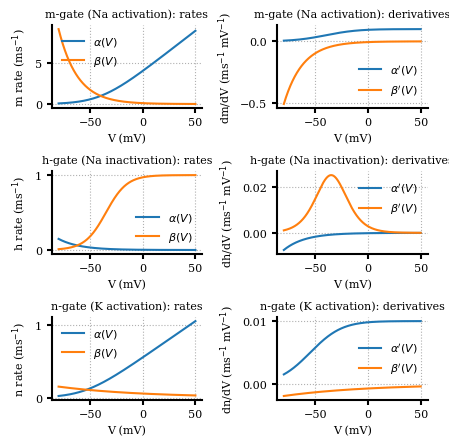

In [16]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ----------------- Numerically stable helpers -----------------
def save_exp(x):
    return jnp.exp(jnp.clip(x, -100.0, 100.0))

def vtrap(x, y):
    z = x / y
    small = jnp.abs(z) < 1e-6
    # Series: x/(e^x - 1) ≈ 1 - x/2 for small x; then multiply by y
    return x / (save_exp(z) - 1.0)

# ----------------- Gate rate definitions (scalar v) -----------------
def alpha_m(v): return 0.1 * vtrap(-(v + 40.0), 10.0)
def beta_m(v):  return 4.0 * save_exp(-(v + 65.0) / 18.0)

def alpha_h(v): return 0.07 * save_exp(-(v + 65.0) / 20.0)
def beta_h(v):  return 1.0 / (save_exp(-(v + 35.0) / 10.0) + 1.0)

def alpha_n(v): return 0.01 * vtrap(-(v + 55.0), 10.0)
def beta_n(v):  return 0.125 * save_exp(-(v + 65.0) / 80.0)

# Derivatives wrt V using automatic differentiation
dalpha_m = jax.grad(alpha_m); dbeta_m  = jax.grad(beta_m)
dalpha_h = jax.grad(alpha_h); dbeta_h  = jax.grad(beta_h)
dalpha_n = jax.grad(alpha_n); dbeta_n  = jax.grad(beta_n)

# Vectorize over a voltage grid in the plausible range [-80, 50] mV
V = jnp.linspace(-80.0, 50.0, 1500)  # mV
vmap = jax.vmap

m_a, m_b = vmap(alpha_m)(V), vmap(beta_m)(V)
h_a, h_b = vmap(alpha_h)(V), vmap(beta_h)(V)
n_a, n_b = vmap(alpha_n)(V), vmap(beta_n)(V)

m_da, m_db = vmap(dalpha_m)(V), vmap(dbeta_m)(V)
h_da, h_db = vmap(dalpha_h)(V), vmap(dbeta_h)(V)
n_da, n_db = vmap(dalpha_n)(V), vmap(dbeta_n)(V)

# Move to NumPy for plotting
V_np = np.array(V)
def to_np(*xs): return [np.array(x) for x in xs]
m_a, m_b, m_da, m_db = to_np(m_a, m_b, m_da, m_db)
h_a, h_b, h_da, h_db = to_np(h_a, h_b, h_da, h_db)
n_a, n_b, n_da, n_db = to_np(n_a, n_b, n_da, n_db)

# ----------------- Plotting -----------------
# ----------------- Plotting -----------------

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(4.5, 4.5))

    def plot_row(row, gate_name, Vx, alpha, beta, dalpha, dbeta, title):
        # Left plot: alpha and beta
        plt.subplot(3, 2, 2*row-1)
        plt.plot(Vx, alpha, label=r"$\alpha(V)$")
        plt.plot(Vx, beta,  label=r"$\beta(V)$")
        plt.title(f"{title}: rates")
        plt.xlabel("V (mV)")
        plt.ylabel(f"{gate_name} rate (ms$^{{-1}}$)")
        plt.grid(True, linestyle=":")
        plt.legend()

        # Right plot: derivatives
        plt.subplot(3, 2, 2*row)
        plt.plot(Vx, dalpha, label=r"$\alpha'(V)$")
        plt.plot(Vx, dbeta,  label=r"$\beta'(V)$")
        plt.title(f"{title}: derivatives")
        plt.xlabel("V (mV)")
        plt.ylabel(f"d{gate_name}/dV (ms$^{{-1}}$ mV$^{{-1}}$)")
        plt.grid(True, linestyle=":")
        plt.legend()

    plot_row(1, "m", V_np, m_a, m_b, m_da, m_db, "m-gate (Na activation)")
    plot_row(2, "h", V_np, h_a, h_b, h_da, h_db, "h-gate (Na inactivation)")
    plot_row(3, "n", V_np, n_a, n_b, n_da, n_db, "n-gate (K activation)")

    plt.tight_layout()
    plt.savefig('rate_HH.svg')